In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

import string 
import spacy
nlp = spacy.load("en_core_web_sm")

## Overview of Naive Bayes and TF-IDF Vectorization 

In Classification tasks where we use a probabilistic model, we want to compute the probability of a all class given the observations, denoted as $P(Y=y|X)$, where $X$ is a vector consisting of $n$ independent variables, and $Y$ is the dependent variable, or the classification target. From the equation $P(Y=y|X)$, using Bayes Theorem, we can convert this equation to $\frac{P(Y)P(X|Y)}{P(X)}$. Solving this equation for each $Y$ would give us a probability for each class, and to obtain a prediction for the given $X$, we would take the $\arg\max_{P(y|X)}$ as the predicted class. <br><br>

Solving this equation $\frac{P(Y)P(X|Y)}{P(X)}$ is however non-trivial. This is because $X$ is a vector of $n$ elements and this makes $P(X|Y)$ difficult to calculate. In Naive Bayes, an assumption is made that all $x_{i}$ are independent of each other. Thus, this equation can be converted to $\frac{P(Y)P(x_{1}|Y)P(x_{2}|Y)....P(x_{n}|Y)}{P(X)}$. Since $P(X)$ is the same for a given value of $X$, the equation be simplified to $P(Y=y|X) = {P(Y) P(x_{1}|Y) P(x_{2}|Y) .... P(x_{n}|Y)}$. Without the independence assumption, $P(X|Y)$ would be equals to $P(x_{1}|Y) P(x_{2}|Y\cap x_{1}) .... P(x_{n}| Y \cap x_{1} \cap... \cap x_{n-1})$, which would be difficult to calculate<br><br>

Prior = $P(Y)$ <br>
Posterior = $P(Y|X)$ <br>
Likelihood = $P(X|Y)$ <br><br>

In the context of suggestion mining, where we use TF-IDF vectorizor to vectorize the text data, $Y = \{0, 1\}$, where $1$ represents a positive prediction that the text has a suggestion, and $0$ is a negative prediction. $X$ would be the data generated from the TF-IDF vectorizor. For TF-IDF vectorizors, we can fit each column of data to a normal distribution, and use that value to estimate the probability for any given $P(x_{i})$.(Gaussian Naive Bayes)

## TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency, and is a simple extension to the simple Bag of Words text vectorization method. This is the product of 2 terms, the Term Frequency (TF) and Inverse Document Frequency (IDF) <br>

$TF(t,d) = f(t, d)$  <br>
$IDF(t, D) =log\frac{N}{|d \in D: t \in d|}$ <br>

In other words, TF is the simply the count of number of times the word appeares within a particular document. IDF is the logarithm of the number of documents $N$ in the entire corpus, divided by the number of documents the term $t$ appears in.

## Data Cleaning

In [2]:
train_data = pd.read_csv('./Data/App_Training.csv')
test_data = pd.read_csv('./Data/App_Test_Labeled.csv')
eval_data = pd.read_csv('./Data/SubtaskA_EvaluationData_labeled.csv', header = None, encoding = 'latin1')
eval_data.columns = ['id', 'sentence', 'label']

train_data.drop(labels = ['0'], axis = 1, inplace = True)
test_data.drop(labels = ['0'], axis = 1, inplace = True)

In [3]:
display(train_data.head())
display(test_data.head())
display(eval_data.head())

,id,sentence,label
0,663_3,Please enable removing language code from the...,1
1,663_4,Note in your csproj file there is a Supported...,0
2,664_1,Wich means the new version not fully replaced...,0
3,664_2,Some of my users will still receive the old x...,0
4,664_3,The store randomly gives the old xap or the n...,0


,id,sentence,label
0,1310_1,I am not asking Microsoft to Gives permission ...,1
1,1312_1,somewhere between Android and iPhone,0
2,1313_1,And in the Windows Store you can flag the App ...,0
3,1313_2,Many thanks Sameh Hi As we know there is a lot...,0
4,1313_3,The idea is that we can develop a regular app ...,1


,id,sentence,label
0,9566,This would enable live traffic aware apps.,0
1,9569,Please try other formatting like bold italics ...,1
2,9576,Since computers were invented to save time I s...,1
3,9577,Allow rearranging if the user wants to change ...,1
4,9579,Add SIMD instructions for better use of ARM NE...,1


In [4]:
train_data['sentence'] = train_data['sentence'].apply(lambda x: " ".join([word.lower() for word in x.split()]))
test_data['sentence'] = test_data['sentence'].apply(lambda x: " ".join([word.lower() for word in x.split()]))
eval_data['sentence'] = eval_data['sentence'].apply(lambda x: " ".join([word.lower() for word in x.split()]))

train_data['sentence'] = train_data['sentence'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))
test_data['sentence'] = test_data['sentence'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))
eval_data['sentence'] = eval_data['sentence'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))


In [5]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
display(train_data.head())
display(test_data.head())
display(eval_data.head())

,id,sentence,label
0,663_3,please enable removing language code from the ...,1
1,663_4,note in your csproj file there is a supportedc...,0
2,664_1,wich means the new version not fully replaced ...,0
3,664_2,some of my users will still receive the old xa...,0
4,664_3,the store randomly gives the old xap or the ne...,0


,id,sentence,label
0,1310_1,i am not asking microsoft to gives permission ...,1
1,1312_1,somewhere between android and iphone,0
2,1313_1,and in the windows store you can flag the app ...,0
3,1313_2,many thanks sameh hi as we know there is a lot...,0
4,1313_3,the idea is that we can develop a regular app ...,1


,id,sentence,label
0,9566,this would enable live traffic aware apps,0
1,9569,please try other formatting like bold italics ...,1
2,9576,since computers were invented to save time i s...,1
3,9577,allow rearranging if the user wants to change ...,1
4,9579,add simd instructions for better use of arm ne...,1


In [36]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

0    0.754706
1    0.245294
Name: label, dtype: float64


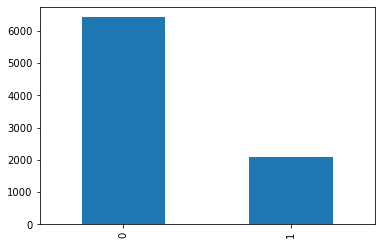

In [5]:
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data['label'].value_counts()/len(train_data))

In [29]:
train_data['label'].value_counts()

0    6415
1    2085
Name: label, dtype: int64

In [6]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(train_data['sentence']).toarray()
count_df = pd.DataFrame(count_matrix, columns = count_vectorizer.get_feature_names_out ())
count_df['label'] = train_data['label']
count_df.head()

,aaa,ab,abandon,abandoned,abbility,abc,abcd,abi,abilities,ability,...,zindex,ziner,zip,zipping,zoom,zooming,zoomlevel,zune,zunes,ıts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


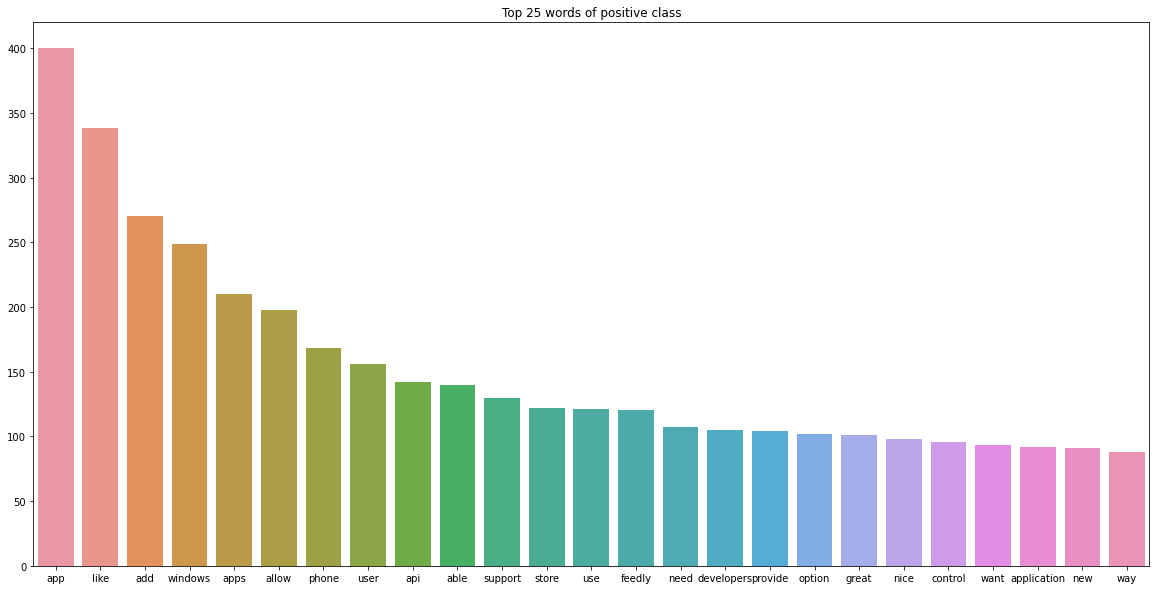

In [37]:
#Plot top 25 words for positive
pos_count_df = count_df[count_df['label'] == 1].copy()
pos_count_df.drop(['label'],axis = 1, inplace = True)
top_25_words = pos_count_df.sum().sort_values(ascending = False).iloc[0:25]
plt.figure(figsize=(20, 10))
plt.title("Top 25 words of positive class")
sns.barplot(x = top_25_words.index, y = top_25_words)

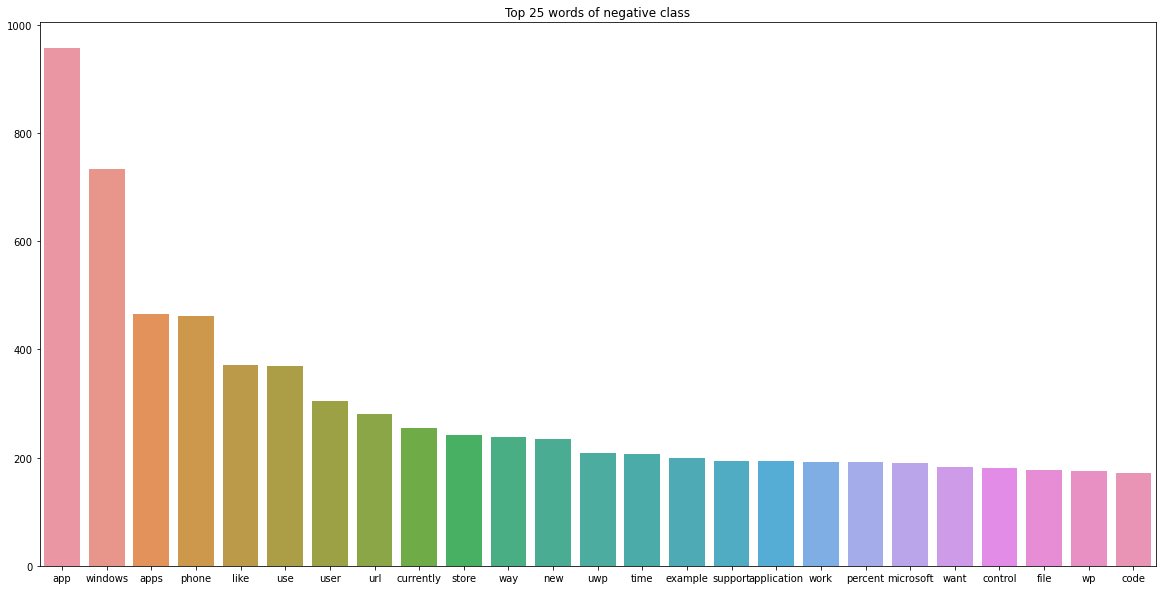

In [39]:
#Plot top 25 words for negative
neg_count_df = count_df[count_df['label'] == 0].copy()
neg_count_df.drop(['label'],axis = 1, inplace = True)
top_25_words = neg_count_df.sum().sort_values(ascending = False).iloc[0:25]
plt.figure(figsize=(20, 10))
plt.title("Top 25 words of negative class")
sns.barplot(x = top_25_words.index, y = top_25_words)

By observation, most of the top few words appear in both negative and positive classes.

In [7]:
#Plot but with bi-grams instead
count_vectorizer = CountVectorizer(ngram_range = (2,2))
count_matrix = count_vectorizer.fit_transform(train_data['sentence']).toarray()
count_df = pd.DataFrame(count_matrix, columns = count_vectorizer.get_feature_names_out ())
count_df['label'] = train_data['label']
count_df.head()

,aaa compliant,ab reset,abandon market,abandon previous,abandoned like,abbility copy,abc sings,abcd ends,abi avoid,abi generating,...,zune property,zune ridiculous,zune software,zune sort,zune tile,zune timefull,zune wireless,zunes audible,ıts gona,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<ipython-input-8-16d42d94d174>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_count_df.drop(['label'],axis = 1, inplace = True)


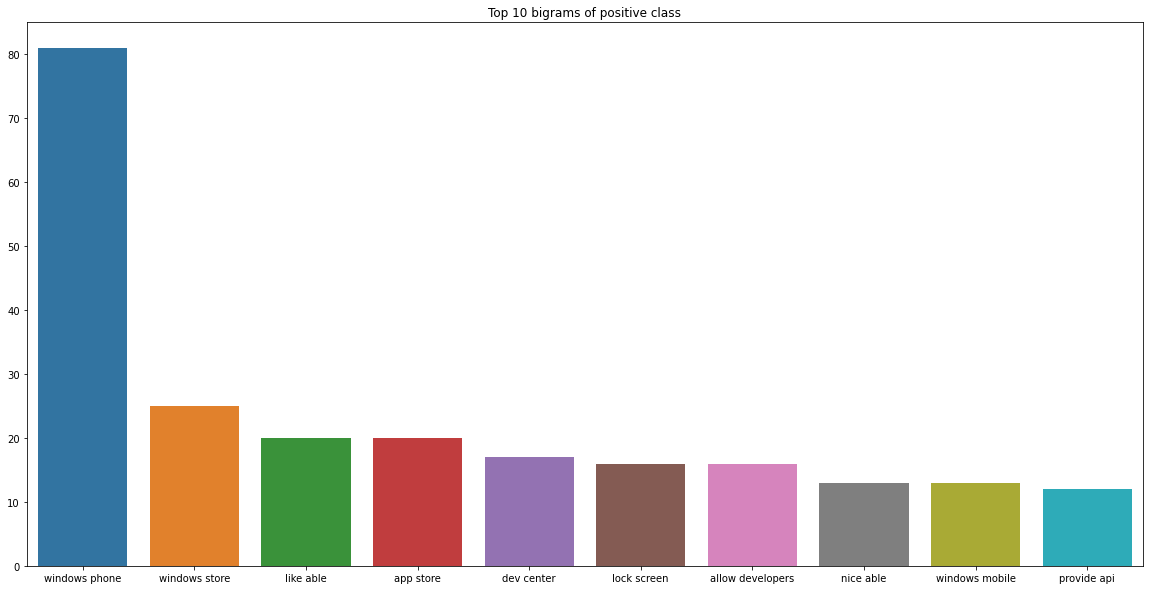

In [8]:
#Plot top 10 bi-grams for positive
pos_count_df = count_df[count_df['label'] == 1]
pos_count_df.drop(['label'],axis = 1, inplace = True)
top_10_words = pos_count_df.sum().sort_values(ascending = False).iloc[0:10]
plt.figure(figsize=(20, 10))
plt.title("Top 10 bi-grams of positive class")
sns.barplot(x = top_10_words.index, y = top_10_words)

<ipython-input-10-1792d2f00ab9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_count_df.drop(['label'],axis = 1, inplace = True)


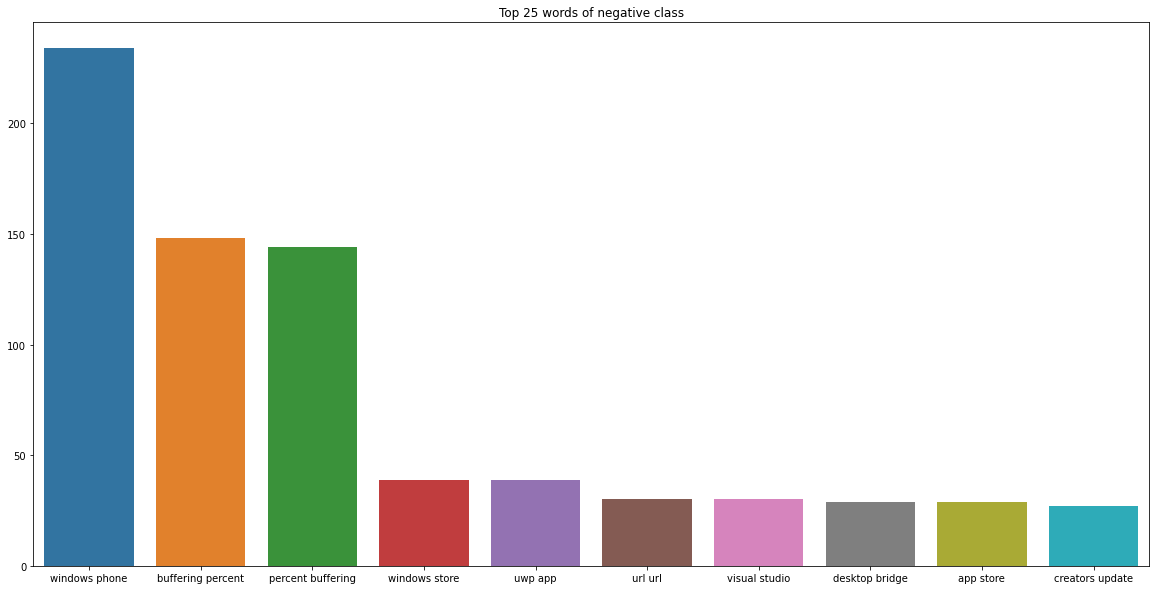

In [10]:
#Plot top 10 bi-gram for negative
neg_count_df = count_df[count_df['label'] == 0]
neg_count_df.drop(['label'],axis = 1, inplace = True)
top_10_words = neg_count_df.sum().sort_values(ascending = False).iloc[0:10]
plt.figure(figsize=(20, 10))
plt.title("Top 10 bi-grams of negative class")
sns.barplot(x = top_10_words.index, y = top_10_words)

## Naive Bayes Classification Model

### Gaussian Naive Bayes

In [48]:



#Do grid search 
kf = KFold(n_splits = 5)
X = train_data['sentence']
Y = train_data['label']
max_df_ranges = [0.85, 0.9, 0.95] 
min_df_ranges = [0.01, 0.02, 0.03]

best_params = {}
best_results = {} 
curr_best_f1 = float('-inf')

for max_df in max_df_ranges:
    for min_df in min_df_ranges:
        f1_scores = []
        recall_scores = []
        accuracy_scores = []
        precision_scores = []
        print(f"Curr Params: max_df = {max_df} min_df = {min_df}")
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df, ngram_range = (1,2))
            tfidf_vectorizer.fit(X_train)
            X_train_vectorized = tfidf_vectorizer.transform(X_train)
            X_test_vectorized = tfidf_vectorizer.transform(X_test)
            clf = GaussianNB()
            clf.fit(X_train_vectorized.toarray(), Y_train)
            Y_pred = clf.predict(X_test_vectorized.toarray())
        
            f1_scores.append(f1_score(Y_test, Y_pred))
            recall_scores.append(recall_score(Y_test, Y_pred))
            precision_scores.append(precision_score(Y_test, Y_pred))
            accuracy_scores.append(accuracy_score(Y_test, Y_pred))
            
            mean_f1 = sum(f1_scores)/5
            if mean_f1 > curr_best_f1:
                curr_best_f1 = mean_f1
                best_params['max_df'] = max_df
                best_params['min_df'] = min_df
                best_results['f1'] = sum(f1_scores)/5
                best_results['precision'] = sum(precision_scores)/5
                best_results['recall'] = sum(recall_scores)/5
                best_results['accuracy'] = sum(accuracy_scores)/5


Curr Params: max_df = 0.85 min_df = 0.01
Curr Params: max_df = 0.85 min_df = 0.02
Curr Params: max_df = 0.85 min_df = 0.03
Curr Params: max_df = 0.9 min_df = 0.01
Curr Params: max_df = 0.9 min_df = 0.02
Curr Params: max_df = 0.9 min_df = 0.03
Curr Params: max_df = 0.95 min_df = 0.01
Curr Params: max_df = 0.95 min_df = 0.02
Curr Params: max_df = 0.95 min_df = 0.03


In [49]:
best_results

{'f1': 0.5517392837153243,
 'precision': 0.45120650612465096,
 'recall': 0.7792463079497491,
 'accuracy': 0.736}

In [50]:
best_params

{'max_df': 0.85, 'min_df': 0.03}

In [51]:
clf = GaussianNB()
tfidf_vectorizer = TfidfVectorizer(max_df = best_params['max_df'], min_df = best_params['min_df'], ngram_range = (1,2))

X_train = train_data['sentence']
Y_train = train_data['label']

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
clf.fit(X_train_vectorized.toarray(), Y_train)

GaussianNB()

In [52]:
X_test = eval_data['sentence']
Y_test = eval_data['label']

X_test_vectorized = tfidf_vectorizer.transform(X_test)
Y_pred = clf.predict(X_test_vectorized.toarray())

print(f"F1 Score: {f1_score(Y_test, Y_pred)}")
print(f"Recall Score: {recall_score(Y_test, Y_pred)}")
print(f"Precision Score: {precision_score(Y_test, Y_pred)}")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred)}")

F1 Score: 0.4011627906976744
Recall Score: 0.7931034482758621
Precision Score: 0.26848249027237353
Accuracy Score: 0.7527010804321729


In [54]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tn, fp, fn, tp)
display(confusion_matrix(Y_test, Y_pred))

558 188 18 69


array([[558, 188],
       [ 18,  69]], dtype=int64)

### Multinomial Naive Bayes

In [8]:
#Do grid search 
kf = KFold(n_splits = 5)
X = train_data['sentence']
Y = train_data['label']
max_df_ranges = [0.85, 0.9, 0.95] 
min_df_ranges = [0.01, 0.02, 0.03]

best_params = {}
best_results = {} 
curr_best_f1 = float('-inf')

for max_df in max_df_ranges:
    for min_df in min_df_ranges:
        f1_scores = []
        recall_scores = []
        accuracy_scores = []
        precision_scores = []
        print(f"Curr Params: max_df = {max_df} min_df = {min_df}")
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            tfidf_vectorizer = CountVectorizer(max_df = max_df, min_df = min_df, ngram_range = (1,2))
            tfidf_vectorizer.fit(X_train)
            X_train_vectorized = tfidf_vectorizer.transform(X_train)
            X_test_vectorized = tfidf_vectorizer.transform(X_test)
            clf = MultinomialNB()
            clf.fit(X_train_vectorized.toarray(), Y_train)
            Y_pred = clf.predict(X_test_vectorized.toarray())
        
            f1_scores.append(f1_score(Y_test, Y_pred))
            recall_scores.append(recall_score(Y_test, Y_pred))
            precision_scores.append(precision_score(Y_test, Y_pred))
            accuracy_scores.append(accuracy_score(Y_test, Y_pred))
            
            mean_f1 = sum(f1_scores)/5
            if mean_f1 > curr_best_f1:
                curr_best_f1 = mean_f1
                best_params['max_df'] = max_df
                best_params['min_df'] = min_df
                best_results['f1'] = sum(f1_scores)/5
                best_results['precision'] = sum(precision_scores)/5
                best_results['recall'] = sum(recall_scores)/5
                best_results['accuracy'] = sum(accuracy_scores)/5


Curr Params: max_df = 0.85 min_df = 0.01
Curr Params: max_df = 0.85 min_df = 0.02
Curr Params: max_df = 0.85 min_df = 0.03
Curr Params: max_df = 0.9 min_df = 0.01
Curr Params: max_df = 0.9 min_df = 0.02
Curr Params: max_df = 0.9 min_df = 0.03
Curr Params: max_df = 0.95 min_df = 0.01
Curr Params: max_df = 0.95 min_df = 0.02
Curr Params: max_df = 0.95 min_df = 0.03


In [9]:
best_results

{'f1': 0.633615973416623,
 'precision': 0.6482982702352655,
 'recall': 0.6423444814614505,
 'accuracy': 0.8355294117647059}

In [10]:
best_params

{'max_df': 0.85, 'min_df': 0.01}

In [14]:
clf = MultinomialNB()
tfidf_vectorizer = CountVectorizer(max_df = best_params['max_df'], min_df = best_params['min_df'], ngram_range = (1,2))

X_train = train_data['sentence']
Y_train = train_data['label']

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
clf.fit(X_train_vectorized.toarray(), Y_train)

MultinomialNB()

In [15]:
X_test = eval_data['sentence']
Y_test = eval_data['label']

X_test_vectorized = tfidf_vectorizer.transform(X_test)
Y_pred = clf.predict(X_test_vectorized.toarray())

print(f"F1 Score: {f1_score(Y_test, Y_pred)}")
print(f"Recall Score: {recall_score(Y_test, Y_pred)}")
print(f"Precision Score: {precision_score(Y_test, Y_pred)}")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred)}")

F1 Score: 0.5714285714285715
Recall Score: 0.6206896551724138
Precision Score: 0.5294117647058824
Accuracy Score: 0.9027611044417767


In [16]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tn, fp, fn, tp)
display(confusion_matrix(Y_test, Y_pred))

698 48 33 54


array([[698,  48],
       [ 33,  54]], dtype=int64)

## Overview of SVM

Support Vector Machines are an extension of Support Vector Classifiers, which are in turn an extension of Maximal margin classifiers. Maximal Margin Classifiers are a linear classifier for linearly separable classification problems. <br> 

In a Maximal Margin Classifier, we find a hyperplane/line (depending) on the dimension that can separate all the observations within the dataset into its respective classes. However, there can be an infinite number of such hyperplanes. Thus, the goal of the MMC is to maximise the margin, which is defined as the shortest distance between a point and the hyperplane. This becomes an optimization problem with the following objective function and constraints: <br>
1. $Maximize M$ = $\frac{1}{\sum\beta_{i}}$
2. Subject to $\sum\beta_{i} = 1$ - Number of independent Variables 
3. and $y_{i}(\beta_{0} + \beta_{1}X_{i1} + ... + \beta_{p}X_{ip}) \geq 1$ <br>

However, the problem with a MMC is that we are unable to handle cases where the data samples are linearly inseparable, and in the MMC is also highly sensitive to outliers. To handle misclassifications, we introduce a slack variable $C$, that allows the observations to violate the margins. The optimization then becomes: <br>

1. $Maximize M$ = $\frac{1}{\sum\beta_{i}}$
2. Subject to $\sum\beta_{i} = 1$ - Number of independent Variables 
3. and $y_{i}(\beta_{0} + \beta_{1}X_{i1} + ... + \beta_{p}X_{ip}) \geq (1 - e)$ <br>
4. and $\sum e_{i} \leq C$ 
5. where $e_{i} \geq 0$

If $e_{i} = 0$, the ith observation is on the correct side of the margin <br>
If $e_{i} \gt 0$, the ith observation is on the wrong side of the margin <br>
If $e_{i} \gt 1$, the ith observation is on the wrong side of the hyperplane <br>
In this case, C is a hyperparameter that can be tuned using cross validation, and it measures the amount of violations of the margin. With a larger C, it allows for more slack, which creates a stronger regularization effect. However. This model is still a linear model with a linear decision boundary. <br>

In order to create a non-linear decision boundary, we need to project the data samples into a higher dimension, then solve the same optimization problem. SVM uses the kernel trick, which represents the datapoints by their pairwise distances. A kernel function is a function that returns a modified dot product. This reduces the time complexity and computational cost required to do the transformation. This allows SVM to create a non-linear decision boundary.


In [17]:
train_data = pd.read_csv('./Data/App_Training.csv')
test_data = pd.read_csv('./Data/App_Test_Labeled.csv')
eval_data = pd.read_csv('./Data/SubtaskA_EvaluationData_labeled.csv', header = None, encoding = 'latin1')
eval_data.columns = ['id', 'sentence', 'label']

train_data.drop(labels = ['0'], axis = 1, inplace = True)
test_data.drop(labels = ['0'], axis = 1, inplace = True)

train_data['sentence'] = train_data['sentence'].apply(lambda x: " ".join([word.lower() for word in x.split()]))
test_data['sentence'] = test_data['sentence'].apply(lambda x: " ".join([word.lower() for word in x.split()]))
eval_data['sentence'] = eval_data['sentence'].apply(lambda x: " ".join([word.lower() for word in x.split()]))

train_data['sentence'] = train_data['sentence'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))
test_data['sentence'] = test_data['sentence'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))
eval_data['sentence'] = eval_data['sentence'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))

In [22]:
from sklearn.svm import SVC
from sklearn.manifold import TSNE

In [23]:
display(train_data.head())
display(test_data.head())
display(eval_data.head())

,id,sentence,label
0,663_3,please enable removing language code from the ...,1
1,663_4,note in your csproj file there is a supportedc...,0
2,664_1,wich means the new version not fully replaced ...,0
3,664_2,some of my users will still receive the old xa...,0
4,664_3,the store randomly gives the old xap or the ne...,0


,id,sentence,label
0,1310_1,i am not asking microsoft to gives permission ...,1
1,1312_1,somewhere between android and iphone,0
2,1313_1,and in the windows store you can flag the app ...,0
3,1313_2,many thanks sameh hi as we know there is a lot...,0
4,1313_3,the idea is that we can develop a regular app ...,1


,id,sentence,label
0,9566,this would enable live traffic aware apps,0
1,9569,please try other formatting like bold italics ...,1
2,9576,since computers were invented to save time i s...,1
3,9577,allow rearranging if the user wants to change ...,1
4,9579,add simd instructions for better use of arm ne...,1


In [26]:
kf = KFold(n_splits = 5)
X = train_data['sentence']
Y = train_data['label']
max_df_ranges = [0.85, 0.9, 0.95] 
min_df_ranges = [0.01, 0.02, 0.03]
vectorizers = ["count", "tfidf"]

best_params = {}
best_results = {} 
curr_best_f1 = float('-inf')

for max_df in max_df_ranges:
    for min_df in min_df_ranges:
        for vectorizer in vectorizers:
            f1_scores = []
            recall_scores = []
            accuracy_scores = []
            precision_scores = []
            print(f"Curr Params: max_df = {max_df} min_df = {min_df} vectorizer = {vectorizer}")
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                if vectorizer == "count":
                    vectorizer = CountVectorizer(max_df = max_df, min_df = min_df, ngram_range = (1,2))
                else:
                    vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df, ngram_range = (1,2))

                vectorizer.fit(X_train)
                X_train_vectorized = vectorizer.transform(X_train)
                X_test_vectorized = vectorizer.transform(X_test)
                clf = SVC()
                clf.fit(X_train_vectorized.toarray(), Y_train)
                Y_pred = clf.predict(X_test_vectorized.toarray())

                f1_scores.append(f1_score(Y_test, Y_pred))
                recall_scores.append(recall_score(Y_test, Y_pred))
                precision_scores.append(precision_score(Y_test, Y_pred))
                accuracy_scores.append(accuracy_score(Y_test, Y_pred))

                mean_f1 = sum(f1_scores)/5
                if mean_f1 > curr_best_f1:
                    curr_best_f1 = mean_f1
                    best_params['max_df'] = max_df
                    best_params['min_df'] = min_df
                    best_params['vectorizer'] = vectorizer
                    best_results['f1'] = sum(f1_scores)/5
                    best_results['precision'] = sum(precision_scores)/5
                    best_results['recall'] = sum(recall_scores)/5
                    best_results['accuracy'] = sum(accuracy_scores)/5

Curr Params: max_df = 0.85 min_df = 0.01 vectorizer = count
Curr Params: max_df = 0.85 min_df = 0.01 vectorizer = tfidf
Curr Params: max_df = 0.85 min_df = 0.02 vectorizer = count
Curr Params: max_df = 0.85 min_df = 0.02 vectorizer = tfidf
Curr Params: max_df = 0.85 min_df = 0.03 vectorizer = count
Curr Params: max_df = 0.85 min_df = 0.03 vectorizer = tfidf
Curr Params: max_df = 0.9 min_df = 0.01 vectorizer = count
Curr Params: max_df = 0.9 min_df = 0.01 vectorizer = tfidf
Curr Params: max_df = 0.9 min_df = 0.02 vectorizer = count
Curr Params: max_df = 0.9 min_df = 0.02 vectorizer = tfidf
Curr Params: max_df = 0.9 min_df = 0.03 vectorizer = count
Curr Params: max_df = 0.9 min_df = 0.03 vectorizer = tfidf
Curr Params: max_df = 0.95 min_df = 0.01 vectorizer = count
Curr Params: max_df = 0.95 min_df = 0.01 vectorizer = tfidf
Curr Params: max_df = 0.95 min_df = 0.02 vectorizer = count
Curr Params: max_df = 0.95 min_df = 0.02 vectorizer = tfidf
Curr Params: max_df = 0.95 min_df = 0.03 vecto

In [27]:
best_results

{'f1': 0.6660824124911213,
 'precision': 0.7628831200390808,
 'recall': 0.6079750692771972,
 'accuracy': 0.8556470588235294}

In [28]:
best_params

{'max_df': 0.85,
 'min_df': 0.01,
 'vectorizer': TfidfVectorizer(max_df=0.85, min_df=0.01, ngram_range=(1, 2))}

In [29]:
clf = SVC()
tfidf_vectorizer = TfidfVectorizer(max_df = best_params['max_df'], min_df = best_params['min_df'], ngram_range = (1,2))

X_train = train_data['sentence']
Y_train = train_data['label']

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
clf.fit(X_train_vectorized.toarray(), Y_train)

SVC()

In [30]:
X_test = eval_data['sentence']
Y_test = eval_data['label']

X_test_vectorized = tfidf_vectorizer.transform(X_test)
Y_pred = clf.predict(X_test_vectorized.toarray())

print(f"F1 Score: {f1_score(Y_test, Y_pred)}")
print(f"Recall Score: {recall_score(Y_test, Y_pred)}")
print(f"Precision Score: {precision_score(Y_test, Y_pred)}")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred)}")

F1 Score: 0.5911949685534591
Recall Score: 0.5402298850574713
Precision Score: 0.6527777777777778
Accuracy Score: 0.921968787515006


In [31]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tn, fp, fn, tp)
display(confusion_matrix(Y_test, Y_pred))

721 25 40 47


array([[721,  25],
       [ 40,  47]], dtype=int64)

In [61]:
kf = KFold(n_splits = 5)
X = train_data['sentence']
Y = train_data['label']tslack

class_weights = ['balanced', {0:1, 1:2}, {0:1, 1:1.5}, {0:1,1:2.5}]
gammas = ['scale',1,2,]
Cs = [1,2,3]


best_params = {}
best_results = {} 
curr_best_f1 = float('-inf')

for C in Cs:
    for gamma in gammas:
        for class_weight in class_weights:
            f1_scores = []
            recall_scores = []
            accuracy_scores = []
            precision_scores = []
            print(f"Curr Params: C = {C} gammas = {gamma} class_weights = {class_weight}")
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))
                vectorizer.fit(X_train)
                X_train_vectorized = vectorizer.transform(X_train)
                X_test_vectorized = vectorizer.transform(X_test)
                clf = SVC(class_weight = class_weight, C = C, gamma = gamma)
                clf.fit(X_train_vectorized.toarray(), Y_train)
                Y_pred = clf.predict(X_test_vectorized.toarray())

                f1_scores.append(f1_score(Y_test, Y_pred))
                recall_scores.append(recall_score(Y_test, Y_pred))
                precision_scores.append(precision_score(Y_test, Y_pred))
                accuracy_scores.append(accuracy_score(Y_test, Y_pred))

                mean_f1 = sum(f1_scores)/5
                if mean_f1 > curr_best_f1:
                    curr_best_f1 = mean_f1
                    best_params['weight'] = class_weight
                    best_params['gamma'] = gamma
                    best_params['C'] = C
                    best_results['f1'] = sum(f1_scores)/5
                    best_results['precision'] = sum(precision_scores)/5
                    best_results['recall'] = sum(recall_scores)/5
                    best_results['accuracy'] = sum(accuracy_scores)/5

Curr Params: C = 1 gammas = scale class_weights = balanced
Curr Params: C = 1 gammas = scale class_weights = {0: 1, 1: 2}
Curr Params: C = 1 gammas = scale class_weights = {0: 1, 1: 1.5}
Curr Params: C = 1 gammas = scale class_weights = {0: 1, 1: 2.5}
Curr Params: C = 1 gammas = 1 class_weights = balanced
Curr Params: C = 1 gammas = 1 class_weights = {0: 1, 1: 2}
Curr Params: C = 1 gammas = 1 class_weights = {0: 1, 1: 1.5}
Curr Params: C = 1 gammas = 1 class_weights = {0: 1, 1: 2.5}
Curr Params: C = 1 gammas = 2 class_weights = balanced
Curr Params: C = 1 gammas = 2 class_weights = {0: 1, 1: 2}
Curr Params: C = 1 gammas = 2 class_weights = {0: 1, 1: 1.5}
Curr Params: C = 1 gammas = 2 class_weights = {0: 1, 1: 2.5}
Curr Params: C = 2 gammas = scale class_weights = balanced
Curr Params: C = 2 gammas = scale class_weights = {0: 1, 1: 2}
Curr Params: C = 2 gammas = scale class_weights = {0: 1, 1: 1.5}
Curr Params: C = 2 gammas = scale class_weights = {0: 1, 1: 2.5}
Curr Params: C = 2 gamma

In [62]:
best_results

{'f1': 0.6939517284883424,
 'precision': 0.6579642056460119,
 'recall': 0.7577369423379058,
 'accuracy': 0.8528235294117648}

In [66]:
best_params

{'weight': 'balanced', 'gamma': 1, 'C': 1}

In [72]:
clf = SVC(class_weight = best_params['weight'], C =  best_params['C'], gamma = best_params['gamma'])
tfidf_vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))

X_train = train_data['sentence']
Y_train = train_data['label']

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
clf.fit(X_train_vectorized.toarray(), Y_train)

X_test = eval_data['sentence']
Y_test = eval_data['label']

X_test_vectorized = tfidf_vectorizer.transform(X_test)
Y_pred = clf.predict(X_test_vectorized.toarray())

print(f"F1 Score: {f1_score(Y_test, Y_pred)}")
print(f"Recall Score: {recall_score(Y_test, Y_pred)}")
print(f"Precision Score: {precision_score(Y_test, Y_pred)}")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred)}")

F1 Score: 0.5650224215246638
Recall Score: 0.7241379310344828
Precision Score: 0.4632352941176471
Accuracy Score: 0.8835534213685474


In [73]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tn, fp, fn, tp)
display(confusion_matrix(Y_test, Y_pred))

673 73 24 63


array([[673,  73],
       [ 24,  63]], dtype=int64)

In [74]:
kf = KFold(n_splits = 5)
X = train_data['sentence']
Y = train_data['label']

class_weights = ['balanced', None]
degrees = [2,3,4]


best_params = {}
best_results = {} 
curr_best_f1 = float('-inf')

for deg in degrees:
    for class_weight in class_weights:
        f1_scores = []
        recall_scores = []
        accuracy_scores = []
        precision_scores = []
        print(f"degree = {deg} class weight = {class_weight}")
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))
            vectorizer.fit(X_train)
            X_train_vectorized = vectorizer.transform(X_train)
            X_test_vectorized = vectorizer.transform(X_test)
            clf = SVC(kernel = 'poly', class_weight = class_weight, degree = deg)
            clf.fit(X_train_vectorized.toarray(), Y_train)
            Y_pred = clf.predict(X_test_vectorized.toarray())

            f1_scores.append(f1_score(Y_test, Y_pred))
            recall_scores.append(recall_score(Y_test, Y_pred))
            precision_scores.append(precision_score(Y_test, Y_pred))
            accuracy_scores.append(accuracy_score(Y_test, Y_pred))

            mean_f1 = sum(f1_scores)/5
            if mean_f1 > curr_best_f1:
                curr_best_f1 = mean_f1
                best_params['weight'] = class_weight
                best_params['degree'] = deg
                best_results['f1'] = sum(f1_scores)/5
                best_results['precision'] = sum(precision_scores)/5
                best_results['recall'] = sum(recall_scores)/5
                best_results['accuracy'] = sum(accuracy_scores)/5

degree = 2 class weight = balanced
degree = 2 class weight = None
degree = 3 class weight = balanced
degree = 3 class weight = None
degree = 4 class weight = balanced
degree = 4 class weight = None


In [76]:
best_params

{'weight': 'balanced', 'degree': 2}

In [78]:
best_results

{'f1': 0.6746838100020767,
 'precision': 0.6601056031454443,
 'recall': 0.7129435896535296,
 'accuracy': 0.8471764705882352}

In [77]:
clf = SVC(kernel = 'poly', class_weight = best_params['weight'], degree = best_params['degree'])
tfidf_vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))

X_train = train_data['sentence']
Y_train = train_data['label']

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
clf.fit(X_train_vectorized.toarray(), Y_train)

X_test = eval_data['sentence']
Y_test = eval_data['label']

X_test_vectorized = tfidf_vectorizer.transform(X_test)
Y_pred = clf.predict(X_test_vectorized.toarray())

print(f"F1 Score: {f1_score(Y_test, Y_pred)}")
print(f"Recall Score: {recall_score(Y_test, Y_pred)}")
print(f"Precision Score: {precision_score(Y_test, Y_pred)}")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred)}")

F1 Score: 0.5544554455445545
Recall Score: 0.6436781609195402
Precision Score: 0.48695652173913045
Accuracy Score: 0.8919567827130852


In [79]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tn, fp, fn, tp)
display(confusion_matrix(Y_test, Y_pred))

687 59 31 56


array([[687,  59],
       [ 31,  56]], dtype=int64)

## XG Boost

In [6]:
import xgboost
import optuna

In [7]:
X = train_data['sentence']
Y = train_data['label']


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000) 
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2)
    kf = KFold(n_splits = 5)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))
        vectorizer.fit(X_train)
        X_train_vectorized = vectorizer.transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)
        clf = xgboost.XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda)
        clf.fit(X_train_vectorized.toarray(), Y_train)
        Y_pred = clf.predict(X_test_vectorized.toarray())
        return f1_score(Y_test, Y_pred)
    
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2022-09-05 01:47:46,409] A new study created in memory with name: no-name-77c8e512-07b9-4ee0-a32f-ae0c32d4b35a
[I 2022-09-05 01:49:39,879] Trial 0 finished with value: 0.6414523449319214 and parameters: {'n_estimators': 843, 'max_depth': 10, 'learning_rate': 0.06216023933264048, 'reg_lambda': 0.31096684141469466}. Best is trial 0 with value: 0.6414523449319214.
[I 2022-09-05 01:50:42,615] Trial 1 finished with value: 0.6533127889060092 and parameters: {'n_estimators': 618, 'max_depth': 7, 'learning_rate': 0.08067371311680485, 'reg_lambda': 1.7024272085976702}. Best is trial 1 with value: 0.6533127889060092.
[I 2022-09-05 01:51:14,521] Trial 2 finished with value: 0.6483870967741935 and parameters: {'n_estimators': 346, 'max_depth': 6, 'learning_rate': 0.02534252016855842, 'reg_lambda': 0.9987680244323739}. Best is trial 1 with value: 0.6533127889060092.
[I 2022-09-05 01:52:29,022] Trial 3 finished with value: 0.6583850931677019 and parameters: {'n_estimators': 461, 'max_depth': 12, 

[I 2022-09-05 02:23:41,568] Trial 31 finished with value: 0.654434250764526 and parameters: {'n_estimators': 232, 'max_depth': 10, 'learning_rate': 0.08221791111709822, 'reg_lambda': 0.6117583581670009}. Best is trial 20 with value: 0.6686838124054464.
[I 2022-09-05 02:24:05,457] Trial 32 finished with value: 0.660436137071651 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.07790535959355319, 'reg_lambda': 0.35453750070317824}. Best is trial 20 with value: 0.6686838124054464.
[I 2022-09-05 02:24:36,898] Trial 33 finished with value: 0.6625577812018489 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.09303946604046916, 'reg_lambda': 1.0501993340931988}. Best is trial 20 with value: 0.6686838124054464.
[I 2022-09-05 02:25:13,266] Trial 34 finished with value: 0.6635658914728682 and parameters: {'n_estimators': 293, 'max_depth': 9, 'learning_rate': 0.08241511180807155, 'reg_lambda': 0.9264966948900104}. Best is trial 20 with value: 0.668683

[I 2022-09-05 02:47:29,190] Trial 62 finished with value: 0.664624808575804 and parameters: {'n_estimators': 560, 'max_depth': 10, 'learning_rate': 0.06712195640747076, 'reg_lambda': 1.4113608210207143}. Best is trial 59 with value: 0.6769230769230768.
[I 2022-09-05 02:48:21,432] Trial 63 finished with value: 0.6490683229813664 and parameters: {'n_estimators': 350, 'max_depth': 11, 'learning_rate': 0.05489988238767769, 'reg_lambda': 1.2133835870375957}. Best is trial 59 with value: 0.6769230769230768.
[I 2022-09-05 02:49:18,434] Trial 64 finished with value: 0.6687211093990754 and parameters: {'n_estimators': 455, 'max_depth': 9, 'learning_rate': 0.07046685334561835, 'reg_lambda': 1.8008229543801773}. Best is trial 59 with value: 0.6769230769230768.
[I 2022-09-05 02:50:04,296] Trial 65 finished with value: 0.6593406593406593 and parameters: {'n_estimators': 403, 'max_depth': 8, 'learning_rate': 0.04772594377678098, 'reg_lambda': 1.724659974979347}. Best is trial 59 with value: 0.676923

[I 2022-09-05 03:09:36,796] Trial 93 finished with value: 0.6635071090047393 and parameters: {'n_estimators': 366, 'max_depth': 6, 'learning_rate': 0.06812143798379372, 'reg_lambda': 1.2196917160963807}. Best is trial 59 with value: 0.6769230769230768.
[I 2022-09-05 03:10:28,234] Trial 94 finished with value: 0.6575342465753425 and parameters: {'n_estimators': 512, 'max_depth': 7, 'learning_rate': 0.074783927166034, 'reg_lambda': 1.033261003201417}. Best is trial 59 with value: 0.6769230769230768.
[I 2022-09-05 03:11:02,074] Trial 95 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 298, 'max_depth': 8, 'learning_rate': 0.08603228266838206, 'reg_lambda': 0.5963048006904113}. Best is trial 59 with value: 0.6769230769230768.
[I 2022-09-05 03:11:36,473] Trial 96 finished with value: 0.6625577812018489 and parameters: {'n_estimators': 273, 'max_depth': 9, 'learning_rate': 0.08116110110225463, 'reg_lambda': 1.3280639105311176}. Best is trial 59 with value: 0.676923076

In [7]:
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []

X = train_data['sentence']
Y = train_data['label']

kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    clf = xgboost.XGBClassifier(n_estimators = 476, max_depth = 10, learning_rate = 0.06304971145218723, reg_lambda = 1.363541219512416)
    clf.fit(X_train_vectorized.toarray(), Y_train)
    Y_pred = clf.predict(X_test_vectorized.toarray())
    
    f1_scores.append(f1_score(Y_test, Y_pred))
    recall_scores.append(recall_score(Y_test, Y_pred))
    precision_scores.append(precision_score(Y_test, Y_pred))
    accuracy_scores.append(accuracy_score(Y_test, Y_pred))
print(f"F1 Score: {sum(f1_scores)/5}")
print(f"Recall Score: {sum(recall_scores)/5}")
print(f"Precision Score: {sum(precision_scores)/5}")
print(f"Accuracy Score: {sum(accuracy_scores)/5}")

F1 Score: 0.673124126514214
Recall Score: 0.6470449363871446
Precision Score: 0.7257001988397525
Accuracy Score: 0.8552941176470588


In [8]:
study.best_params

{'n_estimators': 476,
 'max_depth': 10,
 'learning_rate': 0.06304971145218723,
 'reg_lambda': 1.363541219512416}

In [17]:
study.best_params

{'n_estimators': 451,
 'max_depth': 9,
 'learning_rate': 0.07927128145186134,
 'reg_lambda': 1.477291705778975}

In [9]:
vect = vectorizer = TfidfVectorizer(max_df = 0.85, min_df = 0.01, ngram_range = (1,2))
clf = xgboost.XGBClassifier(n_estimators = study.best_params['n_estimators'],
                           max_depth = study.best_params['max_depth'],
                           learning_rate = study.best_params['learning_rate'],
                           reg_lambda = study.best_params['reg_lambda'])

vect.fit(X)
X_test, Y_test = eval_data['sentence'], eval_data['label']
X_train_vectorized = vect.transform(X)
X_test_vectorized = vect.transform(X_test)

clf.fit(X_train_vectorized.toarray(), Y)
Y_pred = clf.predict(X_test_vectorized.toarray())

print(f"F1 Score: {f1_score(Y_test, Y_pred)}")
print(f"Recall Score: {recall_score(Y_test, Y_pred)}")
print(f"Precision Score: {precision_score(Y_test, Y_pred)}")
print(f"Accuracy Score: {accuracy_score(Y_test, Y_pred)}")

F1 Score: 0.5664739884393063
Recall Score: 0.5632183908045977
Precision Score: 0.5697674418604651
Accuracy Score: 0.9099639855942377


In [10]:
confusion_matrix(Y_test, Y_pred)

array([[709,  37],
       [ 38,  49]], dtype=int64)

### Overall summary of results of Naive Bayes and SVM

Overall, we have 3 main results <br>
1. TF-IDF with Gaussian NB
2. Count Vectorizer with Multinomial NB
3. TF-IDF with SVM 


### Cross Validation Scores

|Model|F1 Score|Precision|Recall|Accuracy|
|---|---|---|---|---|
|TF-IDF with Gaussian NB| 0.5517 | 0.4512 | 0.7792 | 0.7360 |  
|BOW with Multinomial NB| 0.6336 | 0.6483 | 0.6423 | 0.8355 |
|TF-IDF with SVM Radial| 0.6940 | 0.6580 | 0.7577 | 0.8528 |
|TF-IDF with SVM Polynomial| 0.6747 | 0.6601 | 0.7129 | 0.8834 |
|XG Boost | 0.6731 | 0.7257 | 0.6470 | 0.8553 |


### Test Set Scores

|Model|F1 Score|Precision|Recall|Accuracy|
|---|---|---|---|---|
|TF-IDF with Gaussian NB| 0.4012 | 0.2685 | 0.7931 | 0.7527 |  
|BOW with Multinomial NB| 0.5714 | 0.5294 | 0.6207 | 0.9028 |
|TF-IDF with SVM Radial | 0.5650 | 0.4632 | 0.7241 | 0.8836 |
|TF-IDF with SVM Polynomial| 0.5545 | 0.4870 | 0.6437 | 0.8920 |
|XG Boost | 0.5664 | 0.5632 | 0.5697 | 0.9100 | 


### Test Set Confusion Matrices

###### TF-IDF with Gaussian NB
||Predict Negative|Predict Positive|
|---|---|---|
|Actual Negative|558|188|
|Actual Positive|18|69|

###### Count Vectorizer with Multinomial NB
||Predict Negative|Predict Positive|
|---|---|---|
|Actual Negative|698|48|
|Actual Positive|33|54|

###### TF-IDF with SVM Radial
||Predict Negative|Predict Positive|
|---|---|---|
|Actual Negative|673|73|
|Actual Positive|24|63|

###### TF-IDF with SVM Polynomial
||Predict Negative|Predict Positive|
|---|---|---|
|Actual Negative|687|59|
|Actual Positive|31|56|

##### XG Boost 
||Predict Negative|Predict Positive|
|---|---|---|
|Actual Negative|709|37|
|Actual Positive|38|49|